In [1]:
#can we find K16 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import matplotlib.pyplot as p
import astropy.units as u
import funcs
import pickle

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
#Load lightcurve

lc = np.genfromtxt('Lightcurves/K16_clean_noecl.txt')
time = lc[:,0]+2454833
flux = lc[:,1]
err = lc[:,2]

In [8]:
# Kepler 16
cb = funcs.CBSystem(m1 = 0.6897,f1 = 1.,m2 = 0.20255,f2 = 0.01555,
                    ab = 0.22431,r1 = 0.6489 * u.Rsun.to('au'),r2 = 0.22623 * u.Rsun.to('au'),
                    eb = 0.15944,ib = np.deg2rad(90.3401),wb = np.deg2rad(263.464),
                    fb = np.deg2rad(186.53239),
                    mp = .03e-3,ap = 0.7048,rp = 0.7538 * u.Rjupiter.to('au'),ep = 0.0069,
                    ip = np.deg2rad(90.0322),wp = np.deg2rad(318.0),fp = np.deg2rad(148.92),
                    Wp = np.deg2rad(0.003),
                    t0 = 2455212.12316)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = np.deg2rad(148.92)
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
dt = 0.02
#t = np.arange(2454953,2456424,dt)
#t = np.arange(np.min(time),np.max(time),dt)
t = time

41.0790034492
228.79461019691053


In [66]:
#lightcurve statistic - transfer lightcurve to a varying duration statistic. 
#0.1d, 0.15d, 0.2d, .25d, .3d, .35d, 0.4d, .45d, .5d (not all useful for K16, but generally speaking will be)

windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
minpoints = 3
blurfactor = 1.5 #using a blurfactor of 1.5 means a 3 duration window is scanned.
#window lightcurve with duration - 
lcstat = {}
blurlcstat = {}
for win in windows:
    lcstat[win], blurlcstat[win] = funcs.running_mean_gaps(time,flux-1,win,minpoints,blurfactor)


<IPython.core.display.Javascript object>


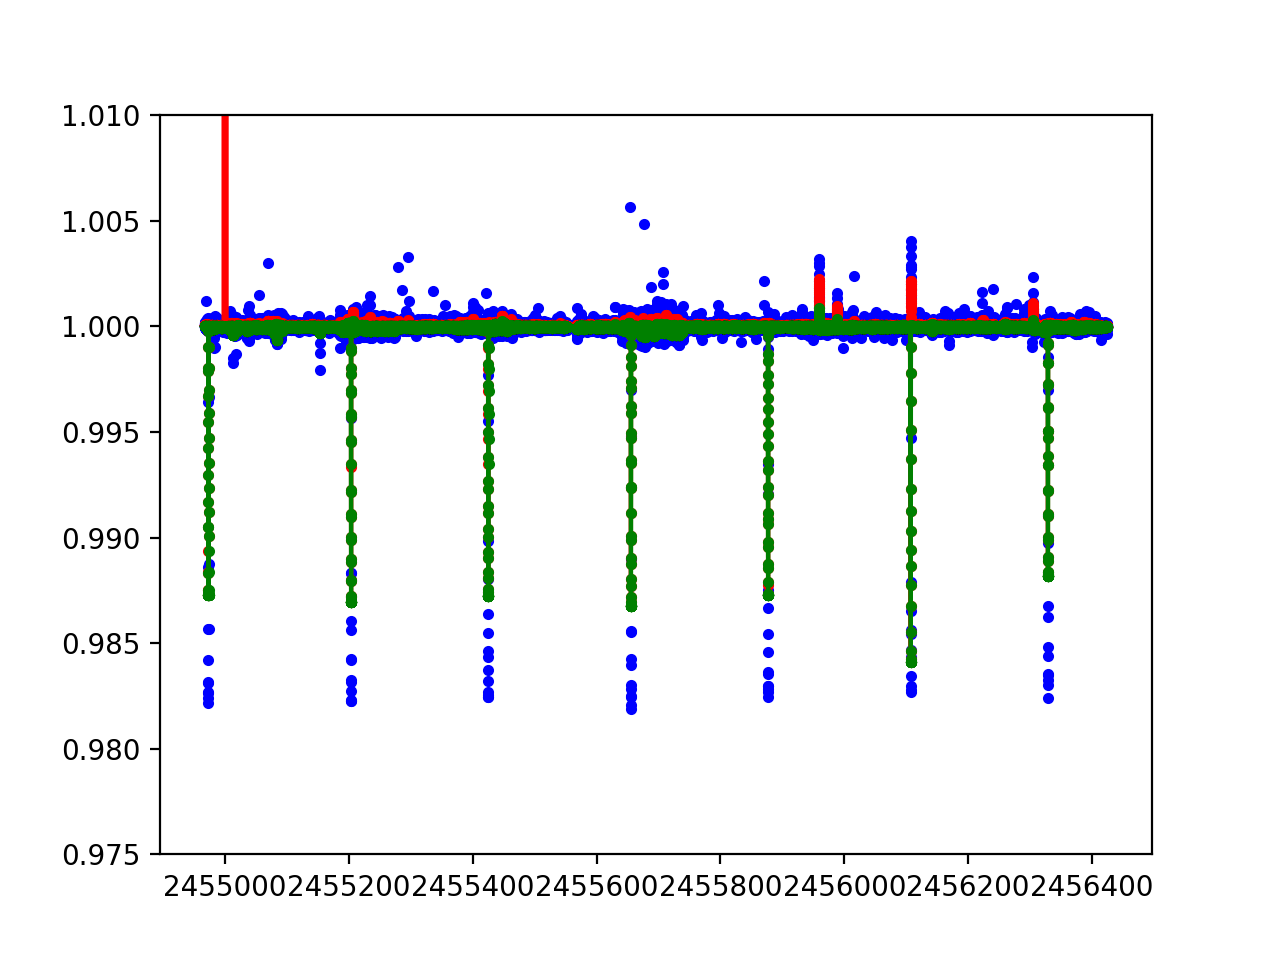

(0.975, 1.01)

In [68]:
p.figure()
p.plot(time,flux,'b.')
p.plot(time,lcstat[0.3]+1,'r.-')
p.plot(time,blurlcstat[0.3]+1,'g.-')
p.ylim(0.975,1.01)

In [5]:
# Load nbody data (deserialize)
with open('K16_tts_all.pickle', 'rb') as handle:
    tts_all = pickle.load(handle)
with open('K16_tds_all.pickle', 'rb') as handle:
    tds_all = pickle.load(handle)


In [22]:
#define range over which to scan (needs to match that loaded. Could extract from dict keys
# but then lose precision
nbins = (1/200. - 1/500.) / (2.5e-6)
invppset = np.linspace(1/500.,1/200.,nbins)
ppset = 1./invppset[::-1] #uniform in frequency
fpset = np.linspace(0,2*np.pi,700)


/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [69]:
windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
periodogram = funcs.make_periodogram(tts_all,tds_all,time,ppset,fpset,windows,blurlcstat)

<IPython.core.display.Javascript object>


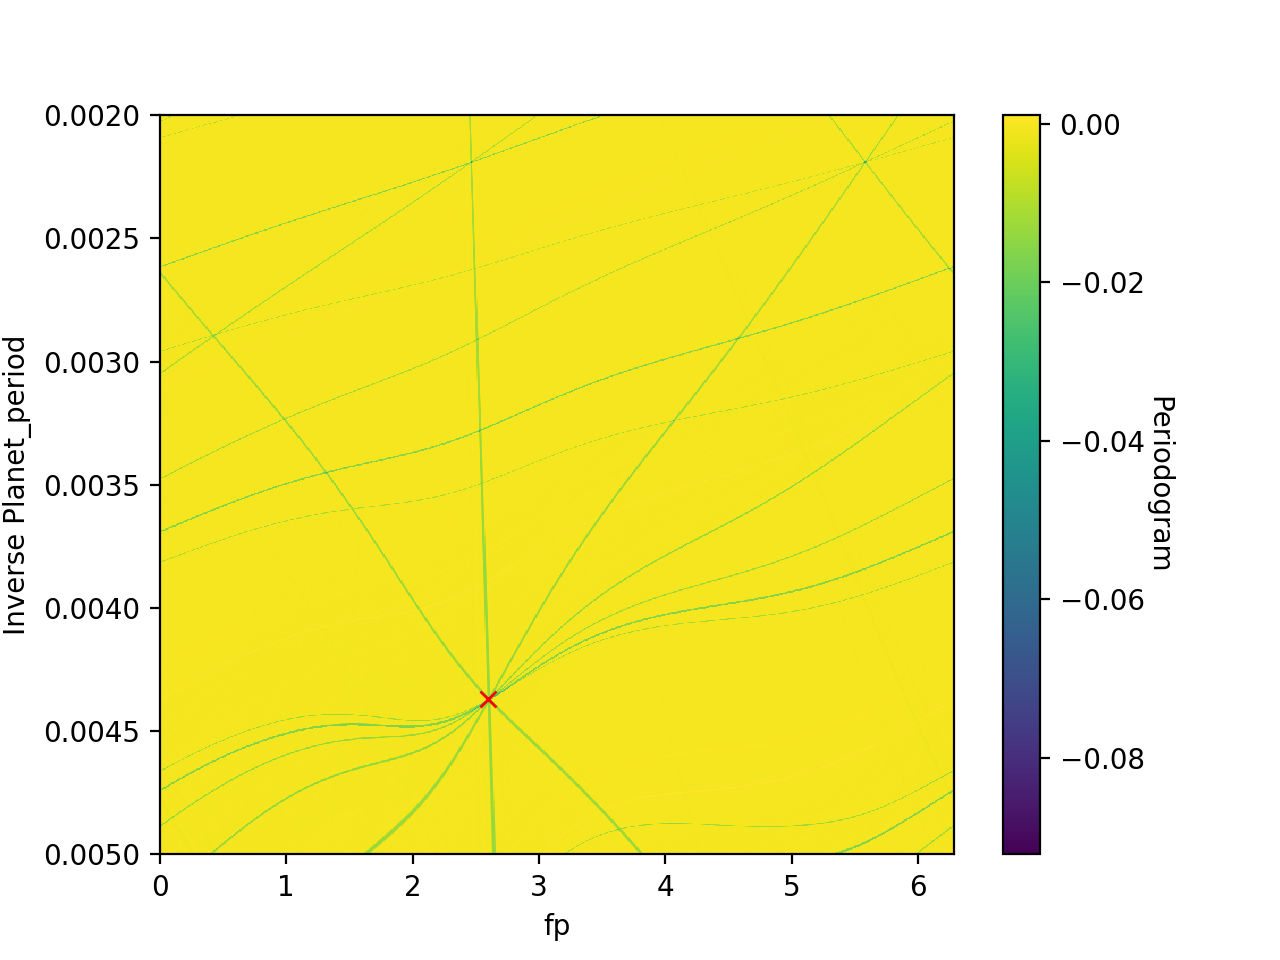

-0.0922233256857
-44.8747081162


In [73]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
print(np.min(periodogram))
print((np.min(periodogram)-np.mean(periodogram))/np.std(periodogram))


In [71]:
print(np.argmin(periodogram))
print(np.unravel_index(np.argmin(periodogram),(len(ppset),len(fpset))))

175289
(250, 289)


In [137]:
#try without K16b transits
lc_notran = np.genfromtxt('Lightcurves/K16_cln_noecl_notran.txt')
time_nt = lc_notran[:,0]
flux_nt = lc_notran[:,1]
err_nt = lc_notran[:,2]

#outlier cut
cutidx = funcs.outlier_cut(time_nt,flux_nt,10, 250)
time_nt_cut, flux_nt_cut = time_nt[cutidx],flux_nt[cutidx]

windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
minpoints = 3
blurfactor = 1.5 #using a blurfactor of 1.5 means a 3 duration window is scanned.
#window lightcurve with duration - 
lcstat_nt = {}
blurlcstat_nt = {}
for win in windows:
    lcstat_nt[win], blurlcstat_nt[win] = funcs.running_mean_gaps(time_nt_cut,flux_nt_cut-1,win,minpoints,blurfactor)
    
periodogram_nt = funcs.make_periodogram(tts_all,tds_all,time_nt,ppset,fpset,windows,blurlcstat_nt)


<IPython.core.display.Javascript object>


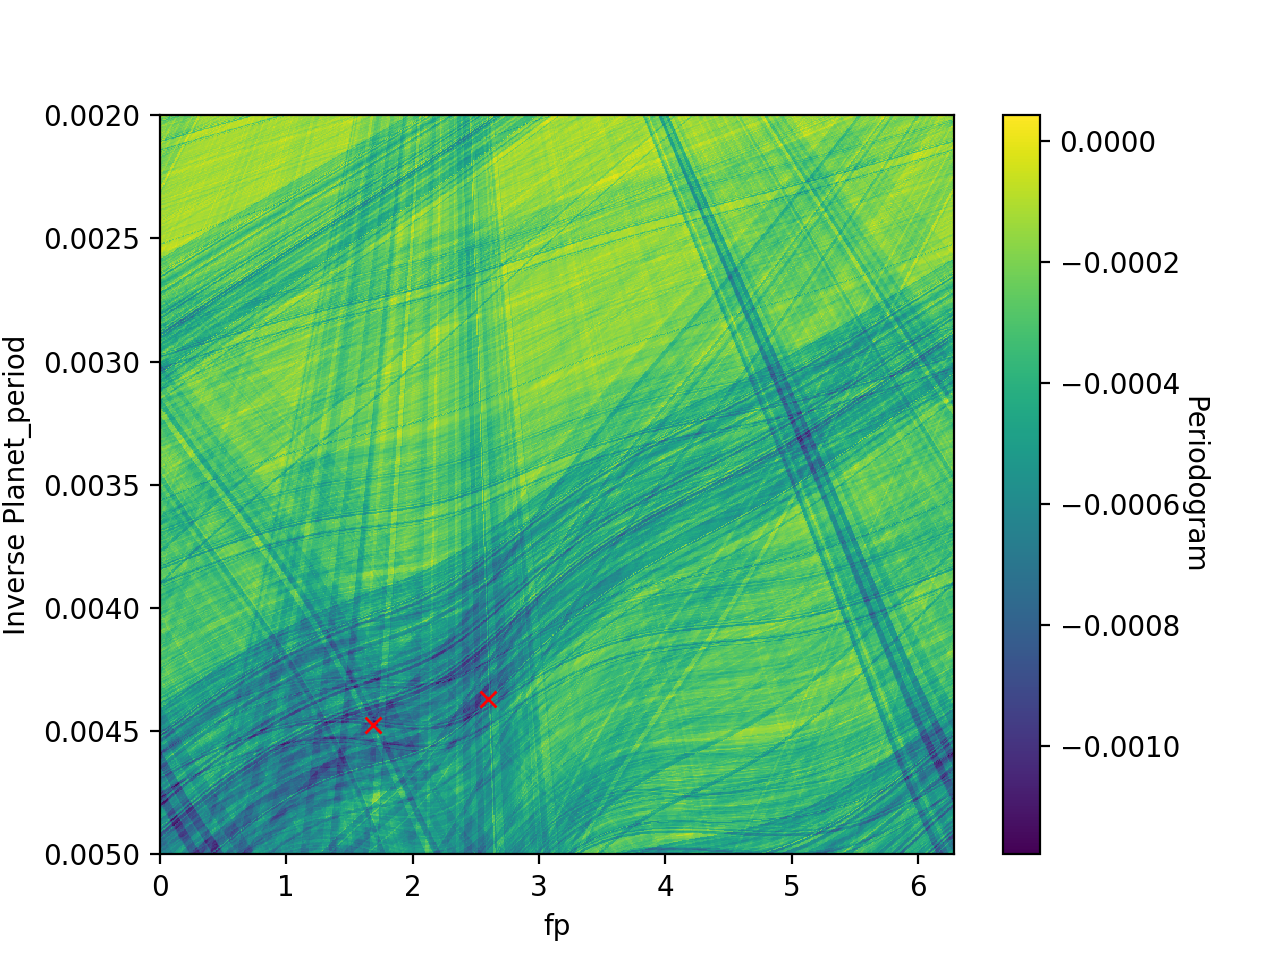

-0.00117937433706
-4.7930287434


In [138]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram_nt,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx = np.unravel_index(np.argmin(periodogram_nt),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'rx')
print(np.min(periodogram_nt))
print((np.min(periodogram_nt)-np.mean(periodogram_nt))/np.std(periodogram_nt))


<IPython.core.display.Javascript object>


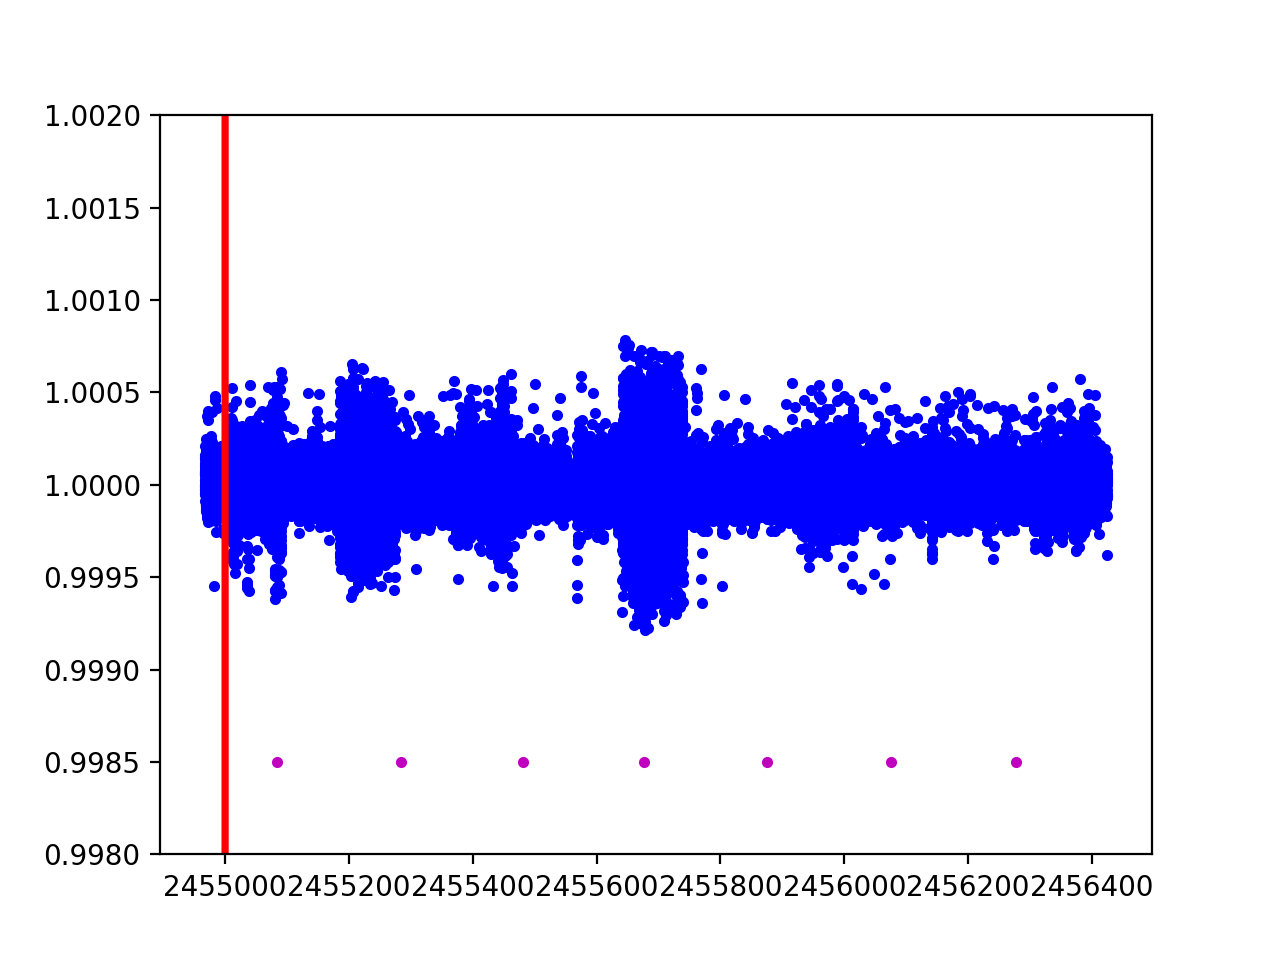

(0.998, 1.002)

In [131]:
p.figure()
p.plot(time_nt_cut,flux_nt_cut,'b.')
p.plot(time_nt_cut,lcstat_nt[0.3],'r.-')
p.plot(time_nt_cut,blurlcstat_nt[0.3],'g.-')

pp = ppset[54]
fp = fpset[11]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

p.ylim(0.998,1.002)

In [139]:
blurlcstat_nt_norm = funcs.normalise_stat(blurlcstat_nt,lcstat_nt,window=250)

In [148]:
periodogram_nt_norm = funcs.make_periodogram(tts_all,tds_all,time_nt_cut,ppset,fpset,
                                             windows,blurlcstat_nt_norm)

periodogram_nt_norm_pertransit = funcs.make_periodogram_pertransit(tts_all,tds_all,time_nt_cut,
                                                                   ppset,fpset,windows,
                                                                   blurlcstat_nt_norm)

<IPython.core.display.Javascript object>


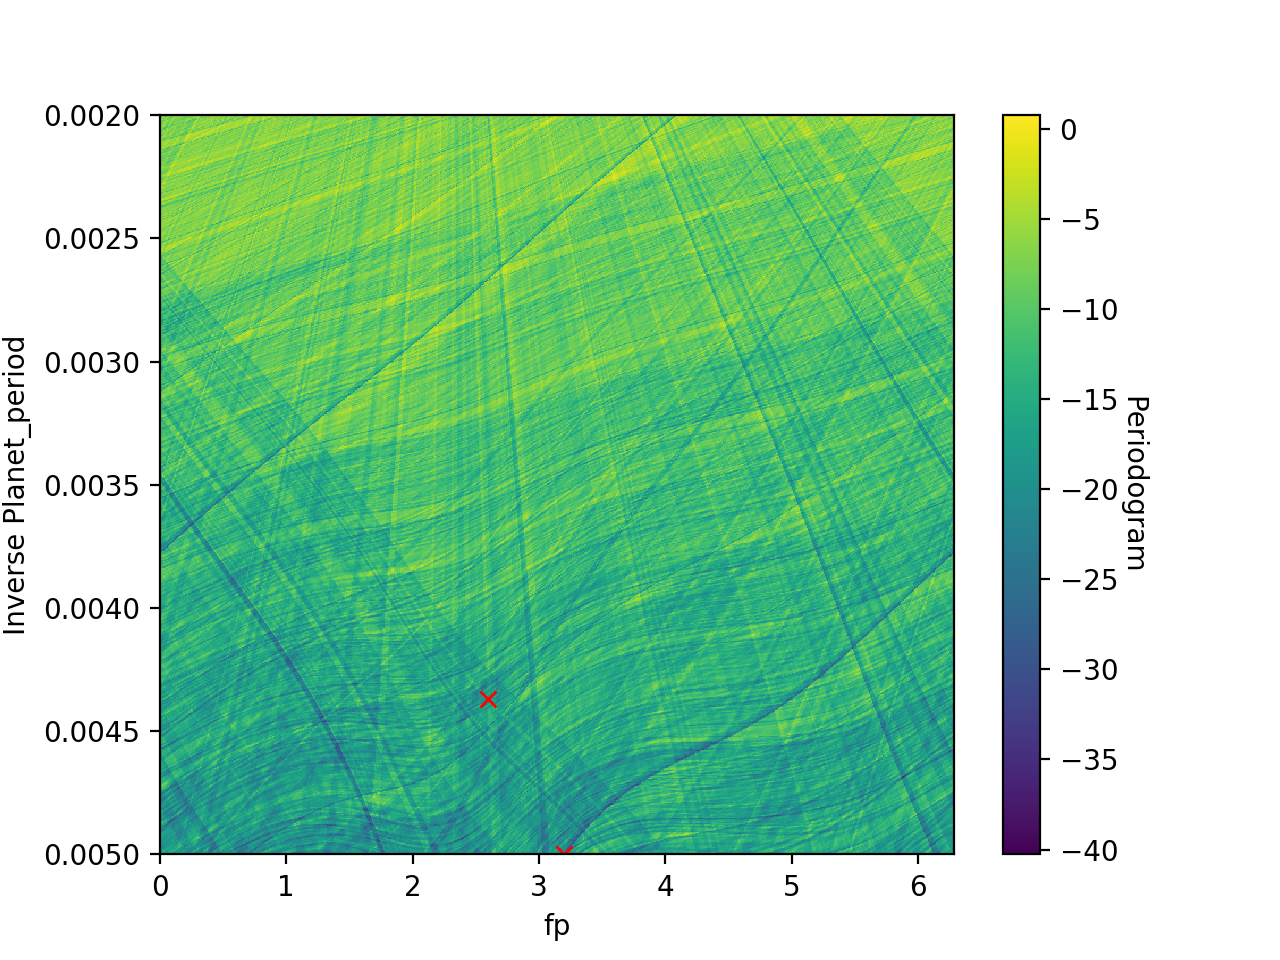

-40.2674092432
-6.37059399876


<IPython.core.display.Javascript object>


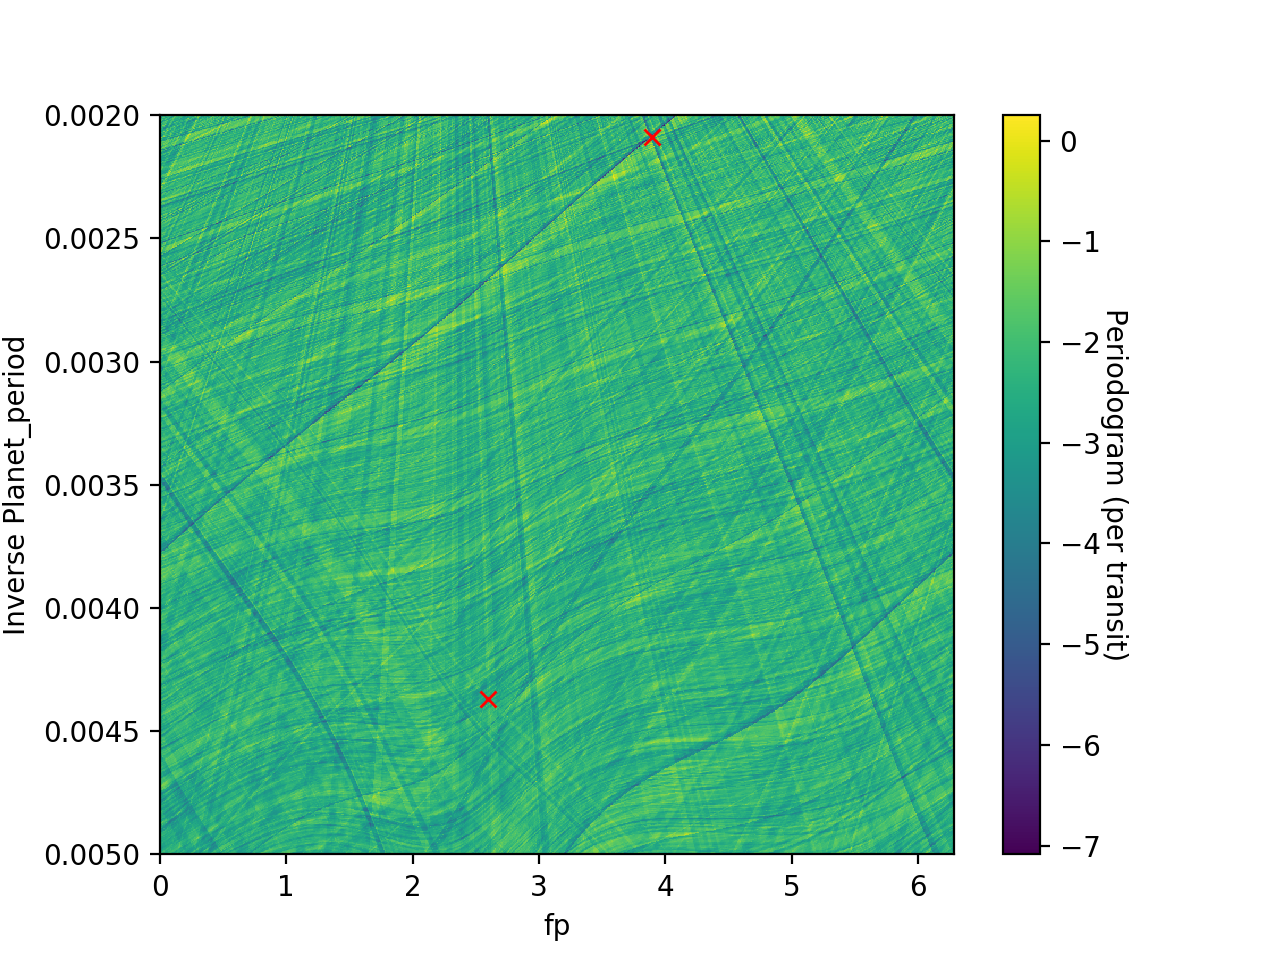

-7.08688867546
-8.48976967947


In [149]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram_nt_norm,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx = np.unravel_index(np.argmin(periodogram_nt_norm),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'rx')
print(np.min(periodogram_nt_norm))
print((np.min(periodogram_nt_norm)-np.mean(periodogram_nt_norm))/np.std(periodogram_nt_norm))

#p.figure()
#p.hist(periodogram_nt_norm,bins=100)

p.figure()
palette = p.cm.viridis
p.imshow(periodogram_nt_norm_pertransit,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram (per transit)', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx_pt = np.unravel_index(np.argmin(periodogram_nt_norm_pertransit),(len(ppset),len(fpset)))
p.plot(fpset[minidx_pt[1]],1./ppset[minidx_pt[0]],'rx')
print(np.min(periodogram_nt_norm_pertransit))
print((np.min(periodogram_nt_norm_pertransit)-np.mean(periodogram_nt_norm_pertransit))/np.std(periodogram_nt_norm_pertransit))


<IPython.core.display.Javascript object>


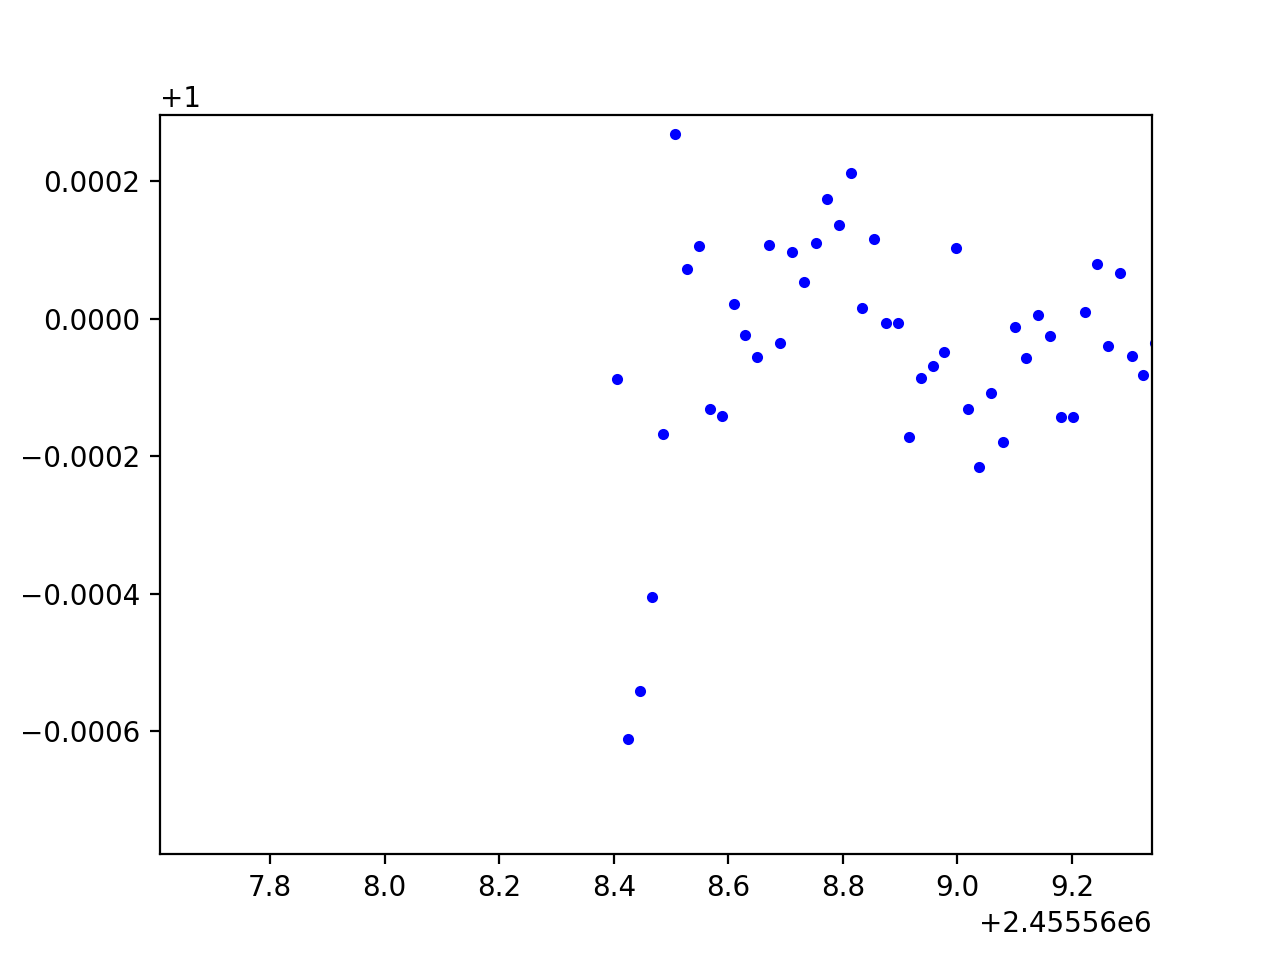

200.100133511


<IPython.core.display.Javascript object>


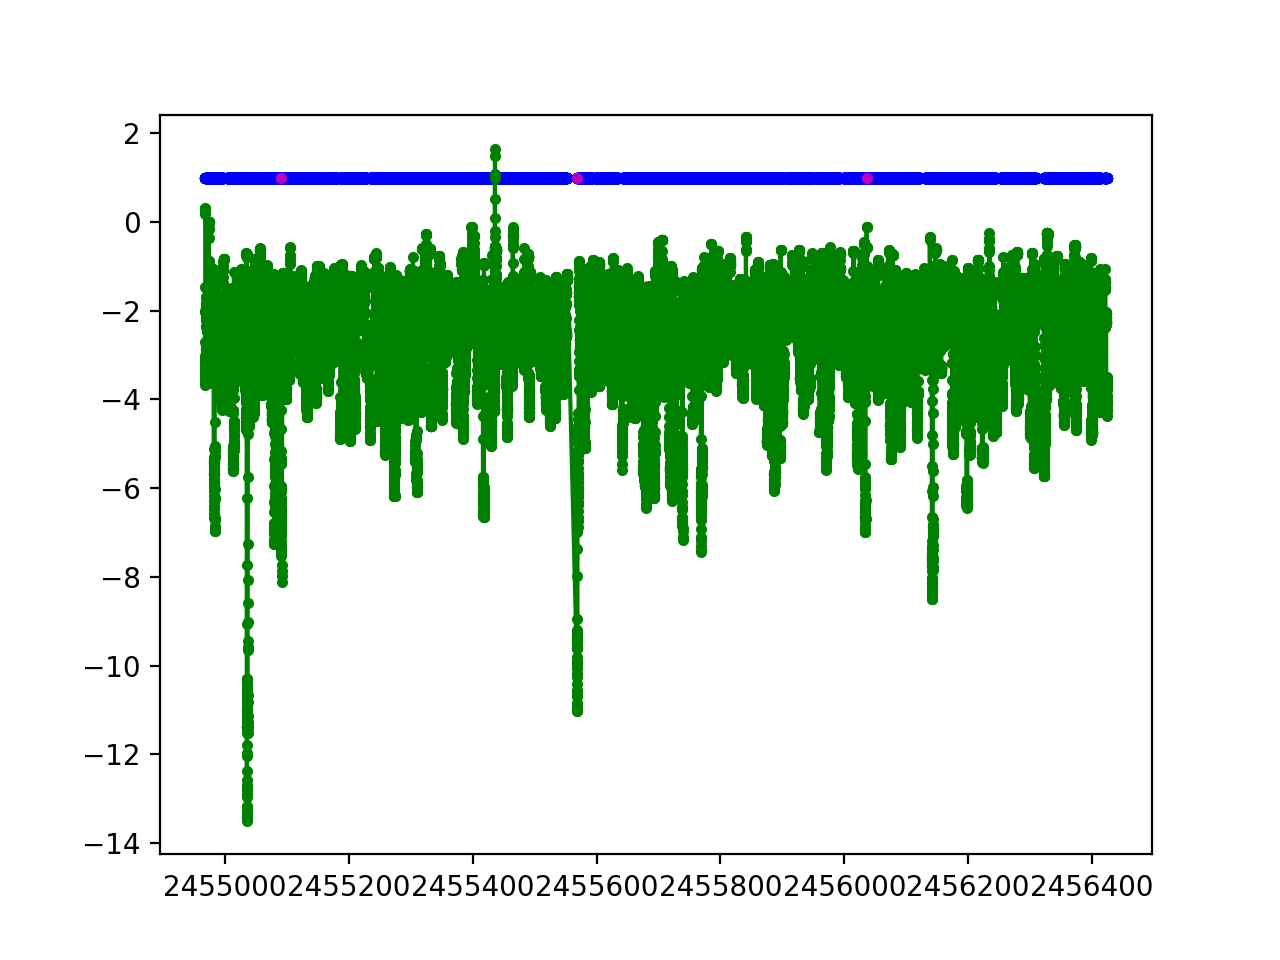

479.025169796


In [150]:
p.figure()
p.plot(time_nt_cut,flux_nt_cut,'b.')
p.plot(time_nt_cut,blurlcstat_nt_norm[0.3],'g.-')

pp = ppset[minidx[0]]
fp = fpset[minidx[1]]
print(pp)

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

#p.ylim(0.998,1.002)

p.figure()
p.plot(time_nt_cut,flux_nt_cut,'b.')
p.plot(time_nt_cut,blurlcstat_nt_norm[0.3],'g.-')

pp = ppset[minidx_pt[0]]
fp = fpset[minidx_pt[1]]
print(pp)
tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

#p.ylim(0.998,1.002)

<IPython.core.display.Javascript object>


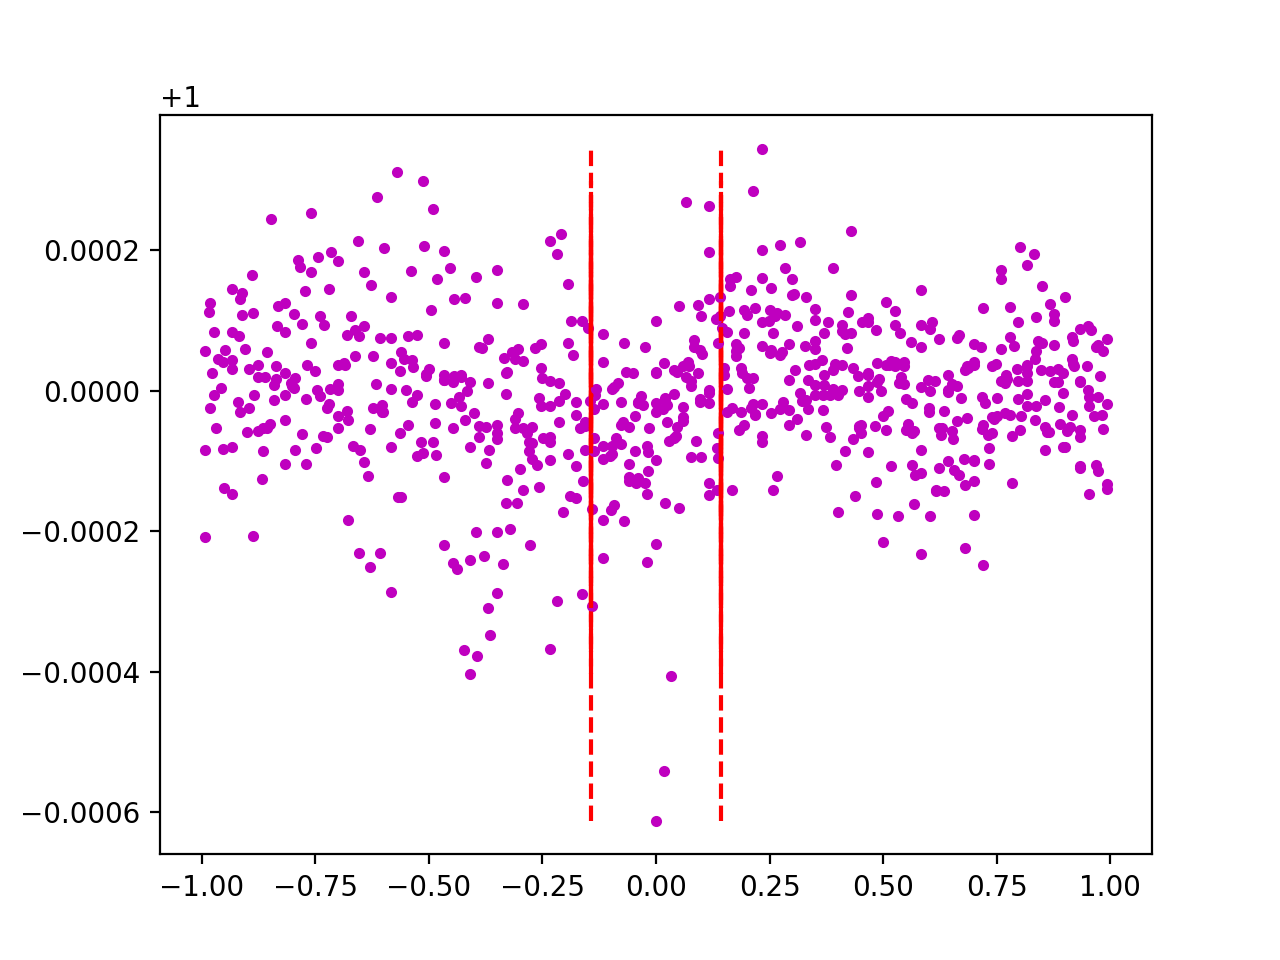

In [151]:
pp = ppset[minidx[0]]
fp = fpset[minidx[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]
p.figure()

for transit,dur in zip(tts,tds):
    #what's the window and blur window?
    blurfactor = 1.5 #1.5 means a 3 duration window is scanned
    minpoints = 3
    
    time_window, flux_window, timescale = funcs.extract_transit_window(transit,dur,time_nt_cut,
                                                                       flux_nt_cut,windows,
                                                                       minpoints,blurfactor)             
    if len(time_window)>0:
        p.plot(timescale,flux_window,'m.')
        p.plot([-1/7.,-1/7.],[np.min(flux_window),np.max(flux_window)],'r--')
        p.plot([1/7.,1/7.],[np.min(flux_window),np.max(flux_window)],'r--')


<IPython.core.display.Javascript object>


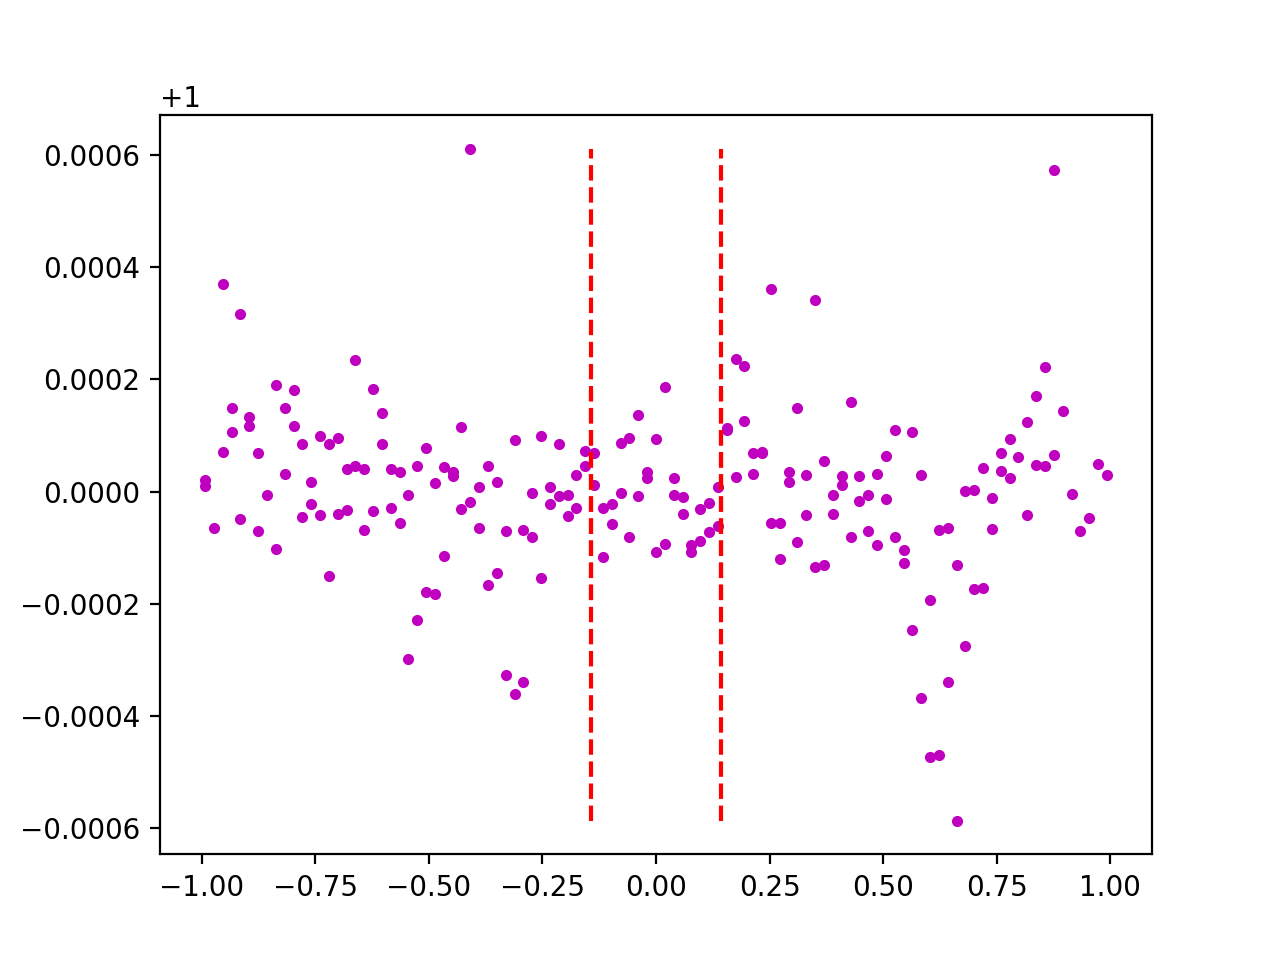

In [152]:
pp = ppset[minidx_pt[0]]
fp = fpset[minidx_pt[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]
p.figure()

for transit,dur in zip(tts,tds):
    #what's the window and blur window?
    blurfactor = 1.5 #1.5 means a 3 duration window is scanned
    minpoints = 3
    
    time_window, flux_window, timescale = funcs.extract_transit_window(transit,dur,time_nt_cut,
                                                                       flux_nt_cut,windows,
                                                                       minpoints,blurfactor)             
    if len(time_window)>0:
        p.plot(timescale,flux_window,'m.')
        p.plot([-1/7.,-1/7.],[np.min(flux_window),np.max(flux_window)],'r--')
        p.plot([1/7.,1/7.],[np.min(flux_window),np.max(flux_window)],'r--')


<IPython.core.display.Javascript object>


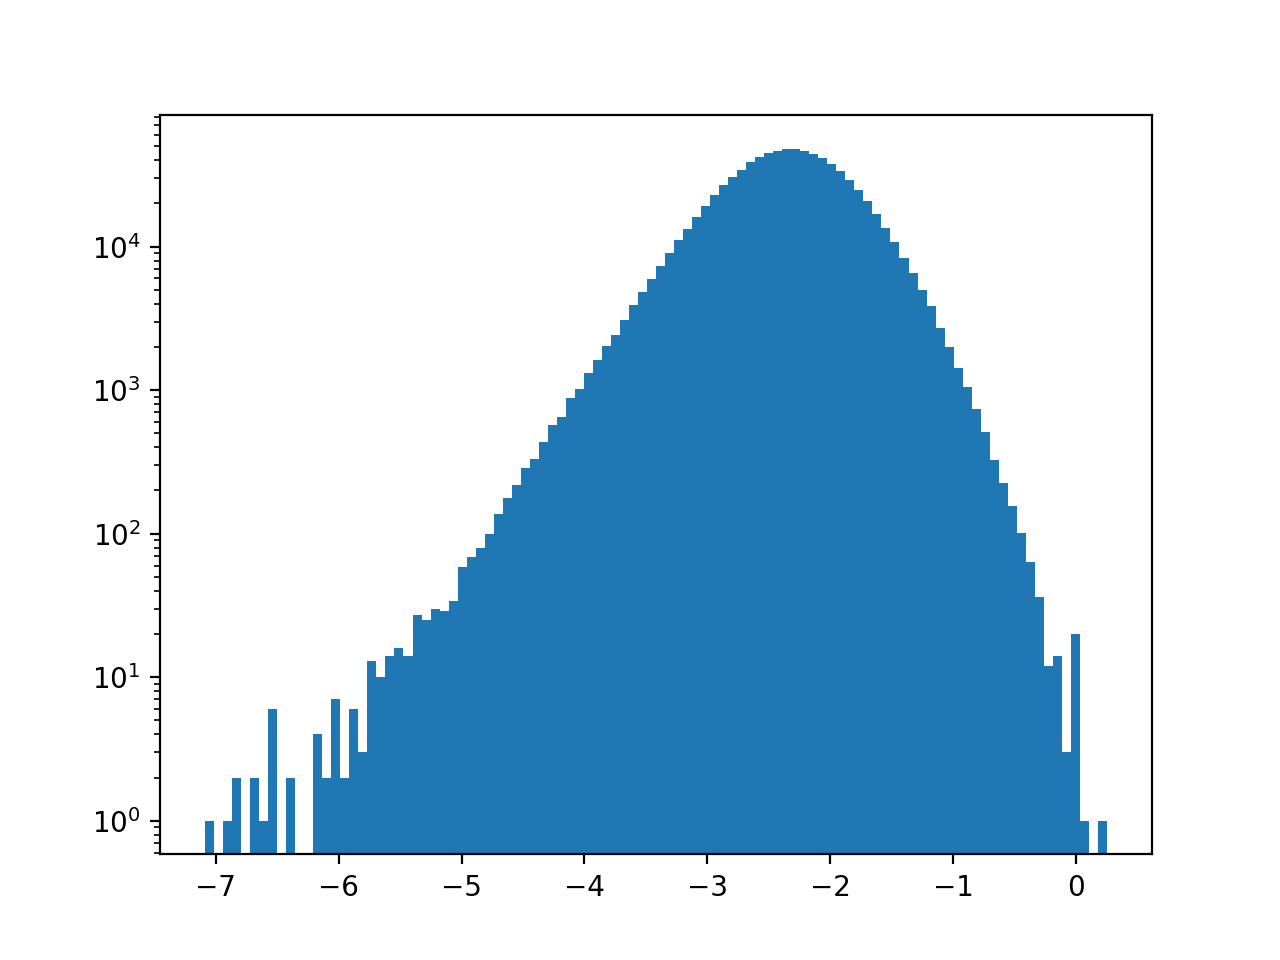

In [153]:
p.figure()
p.hist(periodogram_nt_norm_pertransit.flatten(),bins=100)
p.yscale('log', nonposy='clip')